In [24]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
import tensorflow_addons as tfa  # thư viện cho Attention
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.layers import LSTM, Dense, Input, Attention,concatenate
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer, Dense, Softmax, Concatenate
import tensorflow as tf
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [25]:
data = pd.read_csv(r'C:\Users\57\Desktop\DOANTOTNGHIEP\Data\KichBan1_2\train_data2.csv') 
data.set_index('Ngay', inplace=True)

In [26]:
# Chuẩn hóa dữ liệu để đưa về khoảng [0, 1] để dễ xử lý khi đưa vào mô hình
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [27]:
# def create_sequences(data, seq_length):
#     sequences = []
#     targets = []
#     for i in range(len(data) - seq_length):
#         sequences.append(data[i:i + seq_length])
#         targets.append(data[i + seq_length, 0])  # 'mucNuocHN' là cột đầu tiên
#     return np.array(sequences), np.array(targets)

In [28]:
sequence_length = 1 # Sử dụng 30 ngày để dự đoán
X, y = [], []
for i in range(sequence_length, len(data_scaled)):
    X.append(data_scaled[i-sequence_length:i])
    y.append(data_scaled[i])

X, y = np.array(X), np.array(y)

In [29]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [30]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [31]:
class DropAttention(Layer):
    def __init__(self, d_model, num_heads, dropout_rate=0.1):
        super(DropAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.dropout_rate = dropout_rate

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = Dense(d_model)
        self.wk = Dense(d_model)
        self.wv = Dense(d_model)

        self.dense = Dense(d_model)
        self.dropout = Dropout(self.dropout_rate)

    def split_heads(self, x, batch_size):
        """Chia chiều cuối cùng thành (num_heads, depth)."""
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def scaled_dot_product_attention(self, q, k, v, mask=None):
        """Tính toán attention weights."""
        matmul_qk = tf.matmul(q, k, transpose_b=True)

        # Scale matmul_qk
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        # Softmax to get attention weights
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

        # Drop some attention weights
        attention_weights = self.dropout(attention_weights, training=True)

        output = tf.matmul(attention_weights, v)

        return output, attention_weights

    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len, depth)

        # Scaled dot-product attention with dropout applied
        scaled_attention, attention_weights = self.scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len, d_model)

        return output, attention_weights


In [32]:
# 2. Xây dựng mô hình với LSTM và Attention
input_layer = Input(shape=(X.shape[1], X.shape[2]))
lstm_out = LSTM(64, return_sequences=True)(input_layer)

In [33]:
# Áp dụng lớp GlobalSelfAttention
drop_attention_layer = DropAttention(d_model=64, num_heads=4, dropout_rate=0.1)
attention_output, attention_weights = drop_attention_layer(lstm_out, lstm_out, lstm_out)
concat_output = Concatenate()([lstm_out, attention_output])

In [34]:
# Lớp đầu ra
lstm_out_attention = LSTM(32)(concat_output)
output_layer = Dense(7)(lstm_out_attention)

In [35]:
# Khởi tạo và biên dịch mô hình
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1, 7)]               0         []                            
                                                                                                  
 lstm_2 (LSTM)               (None, 1, 64)                18432     ['input_2[0][0]']             
                                                                                                  
 drop_attention_1 (DropAtte  ((None, None, 64),           16640     ['lstm_2[0][0]',              
 ntion)                       (None, 4, None, None))                 'lstm_2[0][0]',              
                                                                     'lstm_2[0][0]']              
                                                                                            

In [36]:
def nse(y_true, y_pred):
    return 1 - sum((y_true - y_pred)**2) / sum((y_true - np.mean(y_true))**2)

In [37]:
# 3. Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
64/64 [==============================] - 9s 28ms/step - loss: 0.0303 - val_loss: 0.0147
Epoch 2/50
64/64 [==============================] - 1s 8ms/step - loss: 0.0096 - val_loss: 0.0099
Epoch 3/50
64/64 [==============================] - 1s 12ms/step - loss: 0.0076 - val_loss: 0.0079
Epoch 4/50
64/64 [==============================] - 1s 8ms/step - loss: 0.0065 - val_loss: 0.0068
Epoch 5/50
64/64 [==============================] - 0s 7ms/step - loss: 0.0058 - val_loss: 0.0066
Epoch 6/50
64/64 [==============================] - 0s 7ms/step - loss: 0.0056 - val_loss: 0.0066
Epoch 7/50
64/64 [==============================] - 1s 10ms/step - loss: 0.0055 - val_loss: 0.0063
Epoch 8/50
64/64 [==============================] - 1s 10ms/step - loss: 0.0054 - val_loss: 0.0061
Epoch 9/50
64/64 [==============================] - 1s 8ms/step - loss: 0.0054 - val_loss: 0.0065
Epoch 10/50
64/64 [==============================] - 1s 12ms/step - loss: 0.0053 - val_loss: 0.0063
Epoch 11/50
64

In [38]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R² (R-squared):", r2)

# Tính NSE
nse_value = nse(y_test.flatten(), y_pred.flatten())
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

# Tính MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Tính RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)

16/16 [==============================] - 1s 3ms/step
R² (R-squared): 0.790190163051771
Nash-Sutcliffe Efficiency (NSE): 0.8646717592235118
Mean Absolute Error (MAE): 0.04304276300038097
Root Mean Squared Error (RMSE): 0.075019010855003


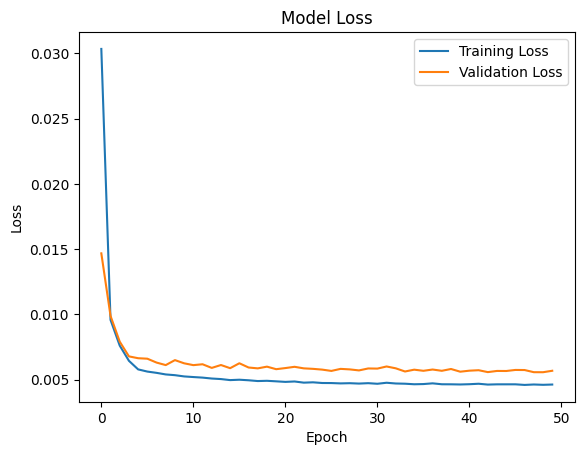

In [39]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [40]:
# 5. Vẽ đồ thị dự báo so sánh với thực tế cho từng mực nước
data_test = pd.read_csv(r'C:\Users\57\Desktop\DOANTOTNGHIEP\Data\KichBan1_2\test_data2_1.csv') 
data_test['Ngay'] = pd.to_datetime(data_test['Ngay'], format='%d/%m/%Y')
data_test.set_index('Ngay', inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_test)

In [41]:
# Chuẩn hóa dữ liệu test bằng scaler đã huấn luyện
data_test_scaled = scaler.transform(data_test)

X_new,Y_new = [],[]
for i in range(sequence_length, len(data_test_scaled)):
    X_new.append(data_test_scaled[i-sequence_length:i])
    Y_new.append(data_test_scaled[i])
X_new = np.array(X_new)
print(len(X_new))
y_new = np.array(Y_new)

737


In [47]:
predictions = model.predict(X_new)
print(predictions)
predictions_new_original = scaler.inverse_transform(predictions)[:,0]
print(predictions_new_original)
y_test_new_original = scaler.inverse_transform(y_new)[:,0]

24/24 [==============================] - 0s 4ms/step
[[0.06867789 0.09272216 0.3109076  ... 0.18844154 0.10275763 0.05747966]
 [0.14578396 0.10578603 0.40120393 ... 0.1807393  0.0993721  0.12703854]
 [0.13537866 0.16243309 0.40862238 ... 0.21232781 0.08844823 0.11428657]
 ...
 [0.1224054  0.04898832 0.23951231 ... 0.10326791 0.14390181 0.10760379]
 [0.13303326 0.05435028 0.28157473 ... 0.09956912 0.11321525 0.11246018]
 [0.21763054 0.05509998 0.26719236 ... 0.0949406  0.14400202 0.12102675]]
[ 90.37426  137.9487   131.52864  132.12573  126.77632  113.981155
 115.23919  123.34733  175.82655  193.88649  184.52608  178.96269
 170.91005  148.40245  124.154686 142.34378  177.53078  221.48323
 233.11429  226.32777  243.89998  227.4461   190.62657  156.34062
 104.46929   70.90379   82.74317  144.8166   216.92113  239.14384
 244.93285  230.46304  235.56909  258.2927   231.53146  209.54779
 170.9122   114.896835  84.064606  85.44576   90.38168  144.29147
 198.67238  231.0273   232.88689  210.43

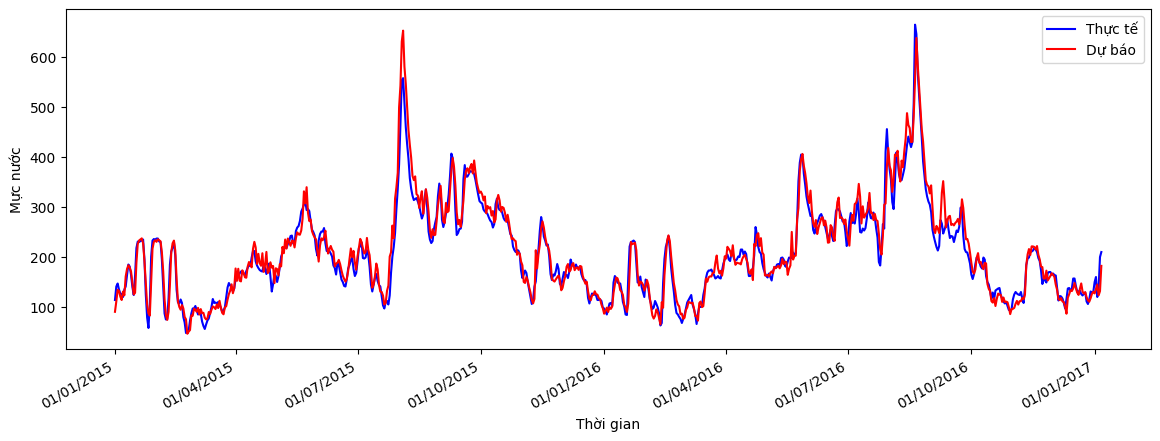

In [43]:
# Đảm bảo các mảng có cùng kích thước
import matplotlib.dates as mdates 
min_length = min(len(data_test.index), len(y_test_new_original), len(predictions_new_original))

# Cắt ngắn mảng theo độ dài nhỏ nhất
dates = data_test.index[:min_length]
y_test_new_original = y_test_new_original[:min_length]
predictions_new_original = predictions_new_original[:min_length]

# Vẽ biểu đồ
plt.figure(figsize=(14, 5))
plt.plot(dates, y_test_new_original, label='Thực tế', color='blue')
plt.plot(dates, predictions_new_original, label='Dự báo', color='red')
plt.xlabel('Thời gian')
plt.ylabel('Mực nước')

# Định dạng ngày tháng
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()


In [45]:
# Tạo mảng ngày bắt đầu từ chỉ số sequence_length của new_data
dates = data_test.index[sequence_length:]

# Đảm bảo số lượng phần tử của dự báo và thực tế khớp với số lượng ngày
min_length = min(len(dates), len(predictions_new_original), len(y_test_new_original))

# Cắt ngắn các mảng để khớp số phần tử nếu cần
dates = dates[:min_length]
predictions_new_original = predictions_new_original[:min_length]
y_test_new_original = y_test_new_original[:min_length]

# Tạo DataFrame với ngày, thực tế và dự báo
df_mucNuocHN = pd.DataFrame({
    'Ngay': dates,
    'ThucTe': y_test_new_original,
    'DuBao': predictions_new_original
})

# Đặt cột 'Ngay' làm chỉ mục
df_mucNuocHN.set_index('Ngay', inplace=True)

# Đặt tên đa cấp cho các cột với nhóm 'mucNuocHaNoi'
df_mucNuocHN.columns = pd.MultiIndex.from_product([['mucNuocHaNoi'], ['ThucTe', 'DuBao']])

# Hiển thị DataFrame
print(df_mucNuocHN)


           mucNuocHaNoi            
                 ThucTe       DuBao
Ngay                               
2015-01-02        114.0   90.374260
2015-01-03        141.0  111.087570
2015-01-04        147.0  134.516785
2015-01-05        135.0  132.125732
2015-01-06        127.0  120.613838
...                 ...         ...
2017-01-03        160.0  136.148300
2017-01-04        120.0  144.957626
2017-01-05        140.0  123.524132
2017-01-06        200.0  131.804840
2017-01-07        210.0  182.278030

[737 rows x 2 columns]
